# Analysing your Oura Ring data using Python, part 1

I've had my Oura Ring for about 10 months now and thought it was about time I got serious about understanding my health. Looking at my scores in the app wasn't really telling me much, so I decided to pull my data using their API V2 and analyse it myself. I looked for examples online, and to be totally honest didn't find any decent blogs on the topic. So as a data scientist with a statistics focus, I thought I'd fill that void. 

In this tutorial (and the others that I have planned) I hope to:
- Learn some things about my own sleep
- Give you ideas and code that you can use to analyse your own Oura / wearable data
- Warn you of all the statistical traps and mistakes we can easily make when analysing our data.

I'm planning for this to be a series of at least 4 parts:

**Part 1** is getting the data and some simple exploratory data analysis

**Part 2** I'll cover analysing trends over time

**Part 3** we'll use regression models to try and understand what whether certain factors like salsa dancing or alcohol improve my sleep. This will be a spicy one, because I'll explain why everyone who I've seen try to do this has got it wrong.

**Part 4** I'll detail how you can use experiments to test lifestyle changes and how they impact your sleep. Once again, in my experience most people do this wrong, but I'll break down the stats for you so you can get it right.

## Let's get started!
First we need to pull our Oura ring data. I define a function that can pull Oura sleep data between 2 dates:

In [ ]:
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from scipy.stats import sem

In [2]:
def get_oura_data(start_date:str, end_date:str, API_token:str)->pd.DataFrame:
  """
  Note date must be in format "YYYY-MM-DD"
  """
  
  URL = f'https://api.ouraring.com/v2/usercollection/daily_sleep' 
  
  params={ 
      'start_date': start_date, 
      'end_date': end_date 
  }
  headers = { 
    'Authorization': f'Bearer {API_token}' 
  }
  response = requests.request('GET', URL, headers=headers, params=params) 
  # get the text of the response, convert to Json dictionary, extract data from the response and convert that data into a dataframe
  data = pd.DataFrame(json.loads(response.text)["data"])
  
  # The sleep component data like deep sleep, REM etc is nested in the data set so we need to pull that out
  sleep_components = pd.json_normalize(data["contributors"]) # Alternatively data_raw['contributors'].apply(pd.Series) would work too
  sleep_data_combined = pd.concat([data,sleep_components],axis = 1) # add our cleaned up sleep component data back onto our original dataframe
  sleep_data_combined.drop(columns={"id",	"contributors", "timestamp"}, inplace=True) # get rid of less useful columns
  
  return sleep_data_combined

Now I pull all my sleep data since I started using the ring.

Note you will need to generate a "personal access token" which is like a secret password that allows you to fetch your Oura data. You can generate one [here](https://cloud.ouraring.com/personal-access-tokens). 
**Do not give this away**. 

In [8]:
PAT = "INSERT YOURS HERE"
sleep_data = get_oura_data(start_date="2023-07-08", end_date="2024-05-27", API_token=PAT)

In [9]:
sleep_data.head()

,day,score,deep_sleep,efficiency,latency,rem_sleep,restfulness,timing,total_sleep
0,2023-07-08,73,97,90,70,83,57,62,70
1,2023-07-09,73,76,81,75,91,54,16,90
2,2023-07-10,75,80,96,86,93,62,52,70
3,2023-07-11,71,88,100,70,88,77,59,53
4,2023-07-12,85,97,100,72,99,67,48,96


The first thing I always do with data is make histograms of all continuous variables and bar charts of all categorical ones. In this case we just have continuous variables so let's histogram the lot:

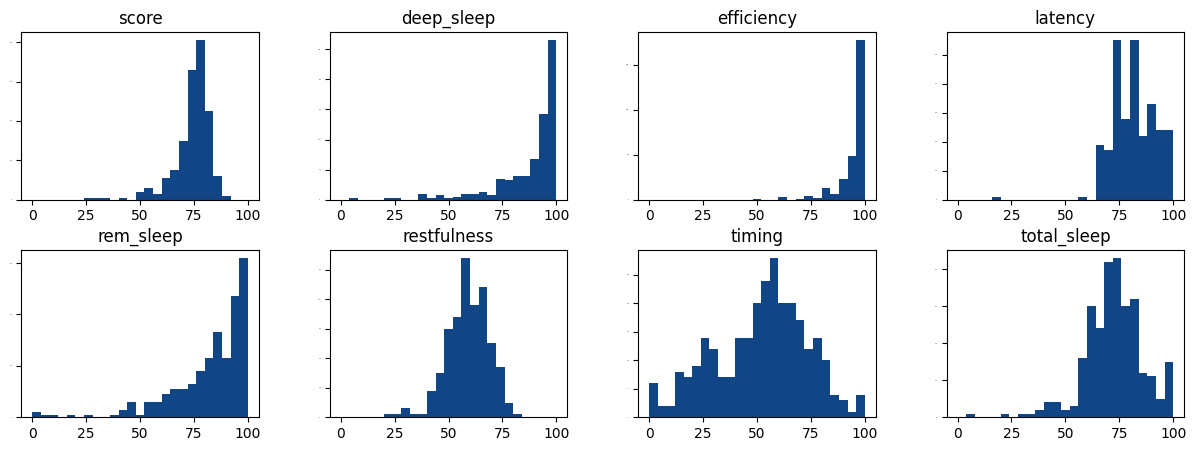

In [10]:
sleep_data.hist(grid=False, figsize=[15,5], bins = 25, range = (0,100), layout=(2,4), ylabelsize=0, color = "#114585") # y size is set to 0 because its not really useful, range (0,100) ensures that all plots go from 0 to 100
plt.show()

A few things stand out:
- My score is centred quite strongly around the 75 mark, but there is a left "tail" of bad nights where my score was between 25 and 50.
- Deep sleep and efficiency are consistently near perfect though deep sleep occasionally falls below 75.
- Latency seems pretty evenly spread between 70 and 100, and almost never falls below that.
- REM sleep is often as high as 100%, but has a left tail just as my general score does.
- Restfulness is centred around 55-60, so not great, and rarely gets to 80.
- Timing is all over the place!
- My total sleep follows my overall sleep score except a few 100s in there.

What have we learned? Well, my sleep is decent overall, with good latency: I usually go to sleep quickly (but not too quickly). I sleep deeply and efficiently. I can now brag that I am "productive even in my sleep" ! But I need to work on ensuring my sleep is restful, and work on consistent sleep and wake up times. My total sleep is decent but could be improved and I occasionally get just the right amount of sleep. 

I had noticed in the app that my restfulness was my biggest weak spot, but a lot of this was new to me, even as someone who checks his scores regularly. We've learned something, awesome!
 
It's no surprise that my sleep scores are occasionally bad: I love going "out out" as we say in England, and a few times a month I don't get to sleep until the wee hours of the morning, usually intoxicated! This seems to impact my REM sleep but interestingly, not always my deep sleep.

## How good is my sleep on average?

In [11]:
print(f"""
      Mean = {sleep_data["score"].mean().round(1)}, 
      Median = {sleep_data["score"].median()}, 
      Range = {sleep_data["score"].min()} - {sleep_data["score"].max()}
      """)


      Mean = 73.6, 
      Median = 76.0, 
      Range = 27 - 90
      


How good is my sleep on average? Well, the mean of my sleep score is 73.6. But wait! Looking at the histogram above, my sleep score is not symmetrical. It has a longer tail of bad scores. This asymmetry means that it is *non-normally distributed*. This means we should not use the mean, as it will be biased by the extreme low values from my nights out partying. If we want to understand how good my *average* night of sleep is, we should use the median, which is 76. Luckily for me, that's a bit higher! 

We can also see my sleep scores vary from the lowest of 27 (yikes!) to a high of 90. Frustratingly, in 10 months I have never beat a sleep score of 90.

### How confident am I in this estimate of average sleep score?
But we can go further than just estimating the average, we can quantify our *confidence* in that average. After all, I could get the age of 5 people from Manchester, take a mean and declare I have measured the average age of Mancunions. However, because I only have 5 data points, I should not be very confidence in my average. We usually represent our confidence in any estimate using a **confidence interval**, usually a **95% confidence interval**. We can be 95% sure that my true average sleep score is inside that range (note this definition of a confidence interval is technically incorrect but it works for all practical purposes).

We need a confidence interval around our median too. To get a 95% confidence interval around our median, I will use a bizarrely named "percentile bootstrap". You can Google the details (or ask ChatGPT to explain the code), but basically this involves creating thousands of simulations of my data, take the median each time, then look at where the median falls 95% of the time.

In [12]:
sample = [np.median(random.choices(sleep_data['score'].tolist(), k = sleep_data.shape[0])) for _ in range(100000)]

print(f"""95% boot CIs around median = {[np.percentile(sample, 2.5),np.percentile(sample,97.5)]} """)

95% boot CIs around median = [75.0, 76.0] 


If we (wrongly) used the mean for our average, we'd compute the 95% confidence intervals using the standard error, which would also be wrong. Let's do that and compare:

In [13]:
mean_sleep_score = sleep_data["score"].mean()
sleep_score_standard_error = sem(sleep_data["score"])
upper_confidence_bound = np.round(mean_sleep_score+(1.96*sleep_score_standard_error),1)
lower_confidence_bound = np.round(mean_sleep_score-(1.96*sleep_score_standard_error),1)

print(f"""95% CIs around mean = {lower_confidence_bound, upper_confidence_bound}""")

95% CIs around mean = (72.6, 74.6)


Notice how this interval is about 2 points, not 1 point. This shows why the median was a better choice here. Not only does the mean underestimate my average sleep quality, but it also gives confidence intervals around that mean that are larger than they should be. It makes us seem less certain than we should be. In reality, I am extremely confident that my average sleep score is 76, perhaps the tiniest bit below.

### How much does my sleep vary night to night?

Ok, so on average my sleep score is 75-76. But looking at the histogram, we can see that it obviously varies around that number. Can we put some numbers on how much it varies?

If we used the mean, we could use the standard deviation. But as we've seen, the mean isn't so trustworthy in my data. So instead we'll use the **median absolute deviation (MAD)**. The MAD basically asks, somewhat confusingly "what is the median distance of a datapoint from the median?". If that makes you brain hurt, don't worry. Just know that it's a measure of how much my sleep varies night to night.

In [14]:
def mad_median(data):
    data = np.array(data)
    median = np.median(data)
    absolute_deviations = np.abs(data - median)
    mad = np.median(absolute_deviations)
    return mad

print(f"""On average my sleep score is {sleep_data["score"].median()}, give or take {mad_median(sleep_data["score"])} points""")

On average my sleep score is 76.0, give or take 4.0 points


We can see that on average my sleep score is 76.0, give or take 4.0 points

## Correlations between sleep components

Next up, let's do some simple correlations between the sleep components. This will give us a rough idea about which sleep components are possible related to each other.
From looking at the histograms above, almost none of the sleep components are normally distributed, so we should use a Spearman's correlation, not the default Pearson. I also don't include the sleep score itself, because it's obviously going to be highly correlated with most of these scores. After all, your Oura sleep score is just a weighted average of all your other scores!

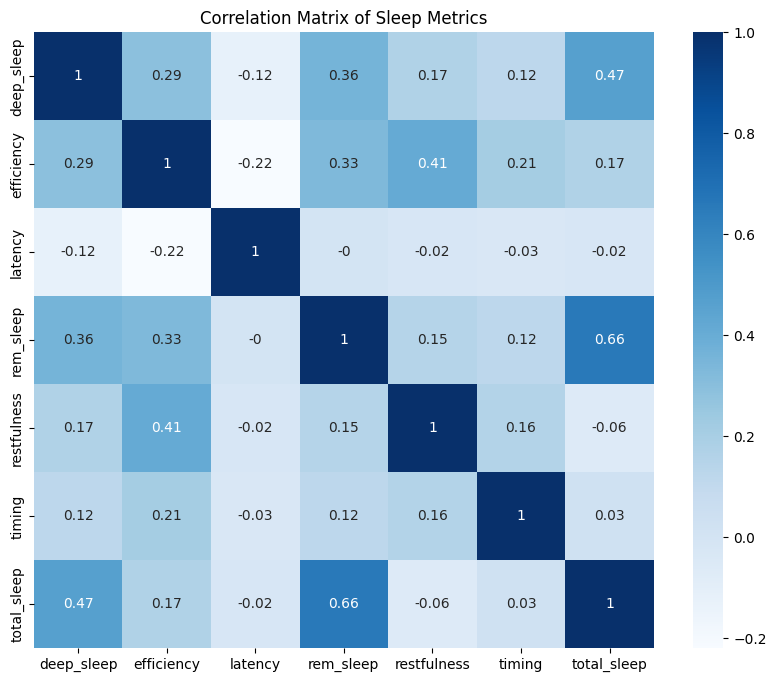

In [15]:
correlation_matrix = sleep_data[['deep_sleep', 'efficiency', 'latency', 'rem_sleep', 'restfulness', 'timing', 'total_sleep']].corr(method = "spearman").round(2)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap="Blues", annot=True)
plt.title('Correlation Matrix of Sleep Metrics')
plt.show()

In my mind, any correlation below 0.2 is not really worth caring about. Anything above that is interesting.

### Dangers of overspimplified correlations
2 things that make this analysis hard to understand:
- Any relationship between 2 components could be caused by a third variable. 
    - For example deep sleep and REM sleep might be correlated because they are both dependent on me getting enough total sleep. When I get a lot of sleep total, both of these go up, and when I get little sleep, they both go down. This produces a correlation even though neither causes the other. 
    - The third variable might be something not captured here, like whether I drink alcohol.
- **Reverse causation**: When 2 components are correlated, its often impossible to truly know what way around the causation is (if there is causation at all). 
    - Restfulness and Efficiency are correlated 0.41, but which causes which?
    - On the plus side, sometimes the correlation only go one way: higher REM sleep probably doesn't cause higher total sleep. 
        - (The only way it could do that is if having more or less REM sleep affects when I wake up, but I generally wake up with an alarm, so that's not likely.)

### Cautious insights
Nonetheless, a few interesting things:
- Total sleep is not correlated with restfulness: when I sleep more, my sleep is not more restful. That means that, annoyingly I should not expect getting more sleep to fix my restfulness problem
- Even though the timing of my sleep is all over the place (see above), it isn't really correlated with anything. This might suggest that going to bed earlier is probably not going to help much.
- Restfulness and efficiency are related, but its not sure how or why. My restfulness seems the weakest component of my sleep but my efficiency is consistently really good. hmmm...
- Latency has a slight *negative* correlation with efficiency. When my latency is worse than usual (i.e. I take longer than normal to fall asleep), my efficiency is better than usual? Could this mean that my body compensates? This might indicate that poor latency is nothing for me to worry about. Maybe I just adapt!

# Summary

In summary, we've learned a fair bit already, about my sleep *and* statistics. 

## What I've learned about my sleep
- I am confident that my sleep is about 76, not bad!
- My sleep timing is all over the place but this may not be an issue as its uncorrelated with anything else
- My latency is strong.
- My restfulness sucks and might not improve if I sleep more

## What we've learned about stats
- When data is non normally distributed, like sleep scores tend to be, you have to use different stats. Means and standard errors would have made me think my sleep was worse on average, and made me less sure what my average sleep was. Unlike the median with perceptile bootstrap confidence intervals.
- Likewise, Spearman's correlations are the way to go for non-normally distributed sleep scores
- It can be hard to interpret correlations but we can learn something.

